# Agri Yield Competition

## Import Libraries

In [3]:
#Session will need restart after install below
!pip install scikeras
!pip install -U scikit-learn scikeras

In [26]:
#File Access
from google.colab import files

#Data Handling
import pandas as pd
import numpy as np

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

#XGBoost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

#Neural Networks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

## Data Import

Data is improted directly from the Kaggle competition page using personal kaggle token.

In [3]:
#Upload kaggle token
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"patrickbarron01","key":"4701f0e323ef2bbf42919a55d37be83f"}'}

In [4]:
#Create directorie for kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#Download dataset, unzip and check success
!kaggle competitions download -c agriyield-2025
!unzip agriyield-2025.zip -d agri_yield_data

!ls agri_yield_data

agriyield-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  agriyield-2025.zip
replace agri_yield_data/data_description.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: agri_yield_data/data_description.md  
  inflating: agri_yield_data/sample_submission.csv  
  inflating: agri_yield_data/test.csv  
  inflating: agri_yield_data/train.csv  
data_description.md  sample_submission.csv  test.csv  train.csv


## EDA

Brief EDA of the given dataset. The dataset looks reduced to remove any obvious or expected strong relationships btwene inputs. Nothing obviously stands out as strong predictor of yield.

In [6]:
df = pd.read_csv('agri_yield_data/train.csv')

In [7]:
df.head()

field_id  soil_ph  organic_matter  sand_pct  temperature  humidity  \
0   F00001     6.25            2.66      41.6         25.2        70   
1   F00002     6.70            3.66      40.2         26.9        78   
2   F00003     7.21            3.45      40.0         27.6        66   
3   F00004     5.73            2.48      56.9         29.6        79   
4   F00005     6.88            3.61      30.6         25.0        80   

   rainfall  ndvi   yield  
0     110.2  0.46  4105.8  
1     126.3  0.59  4247.8  
2     109.4  0.64  4021.8  
3     155.3  0.62  4326.8  
4     172.6  0.62  3708.0

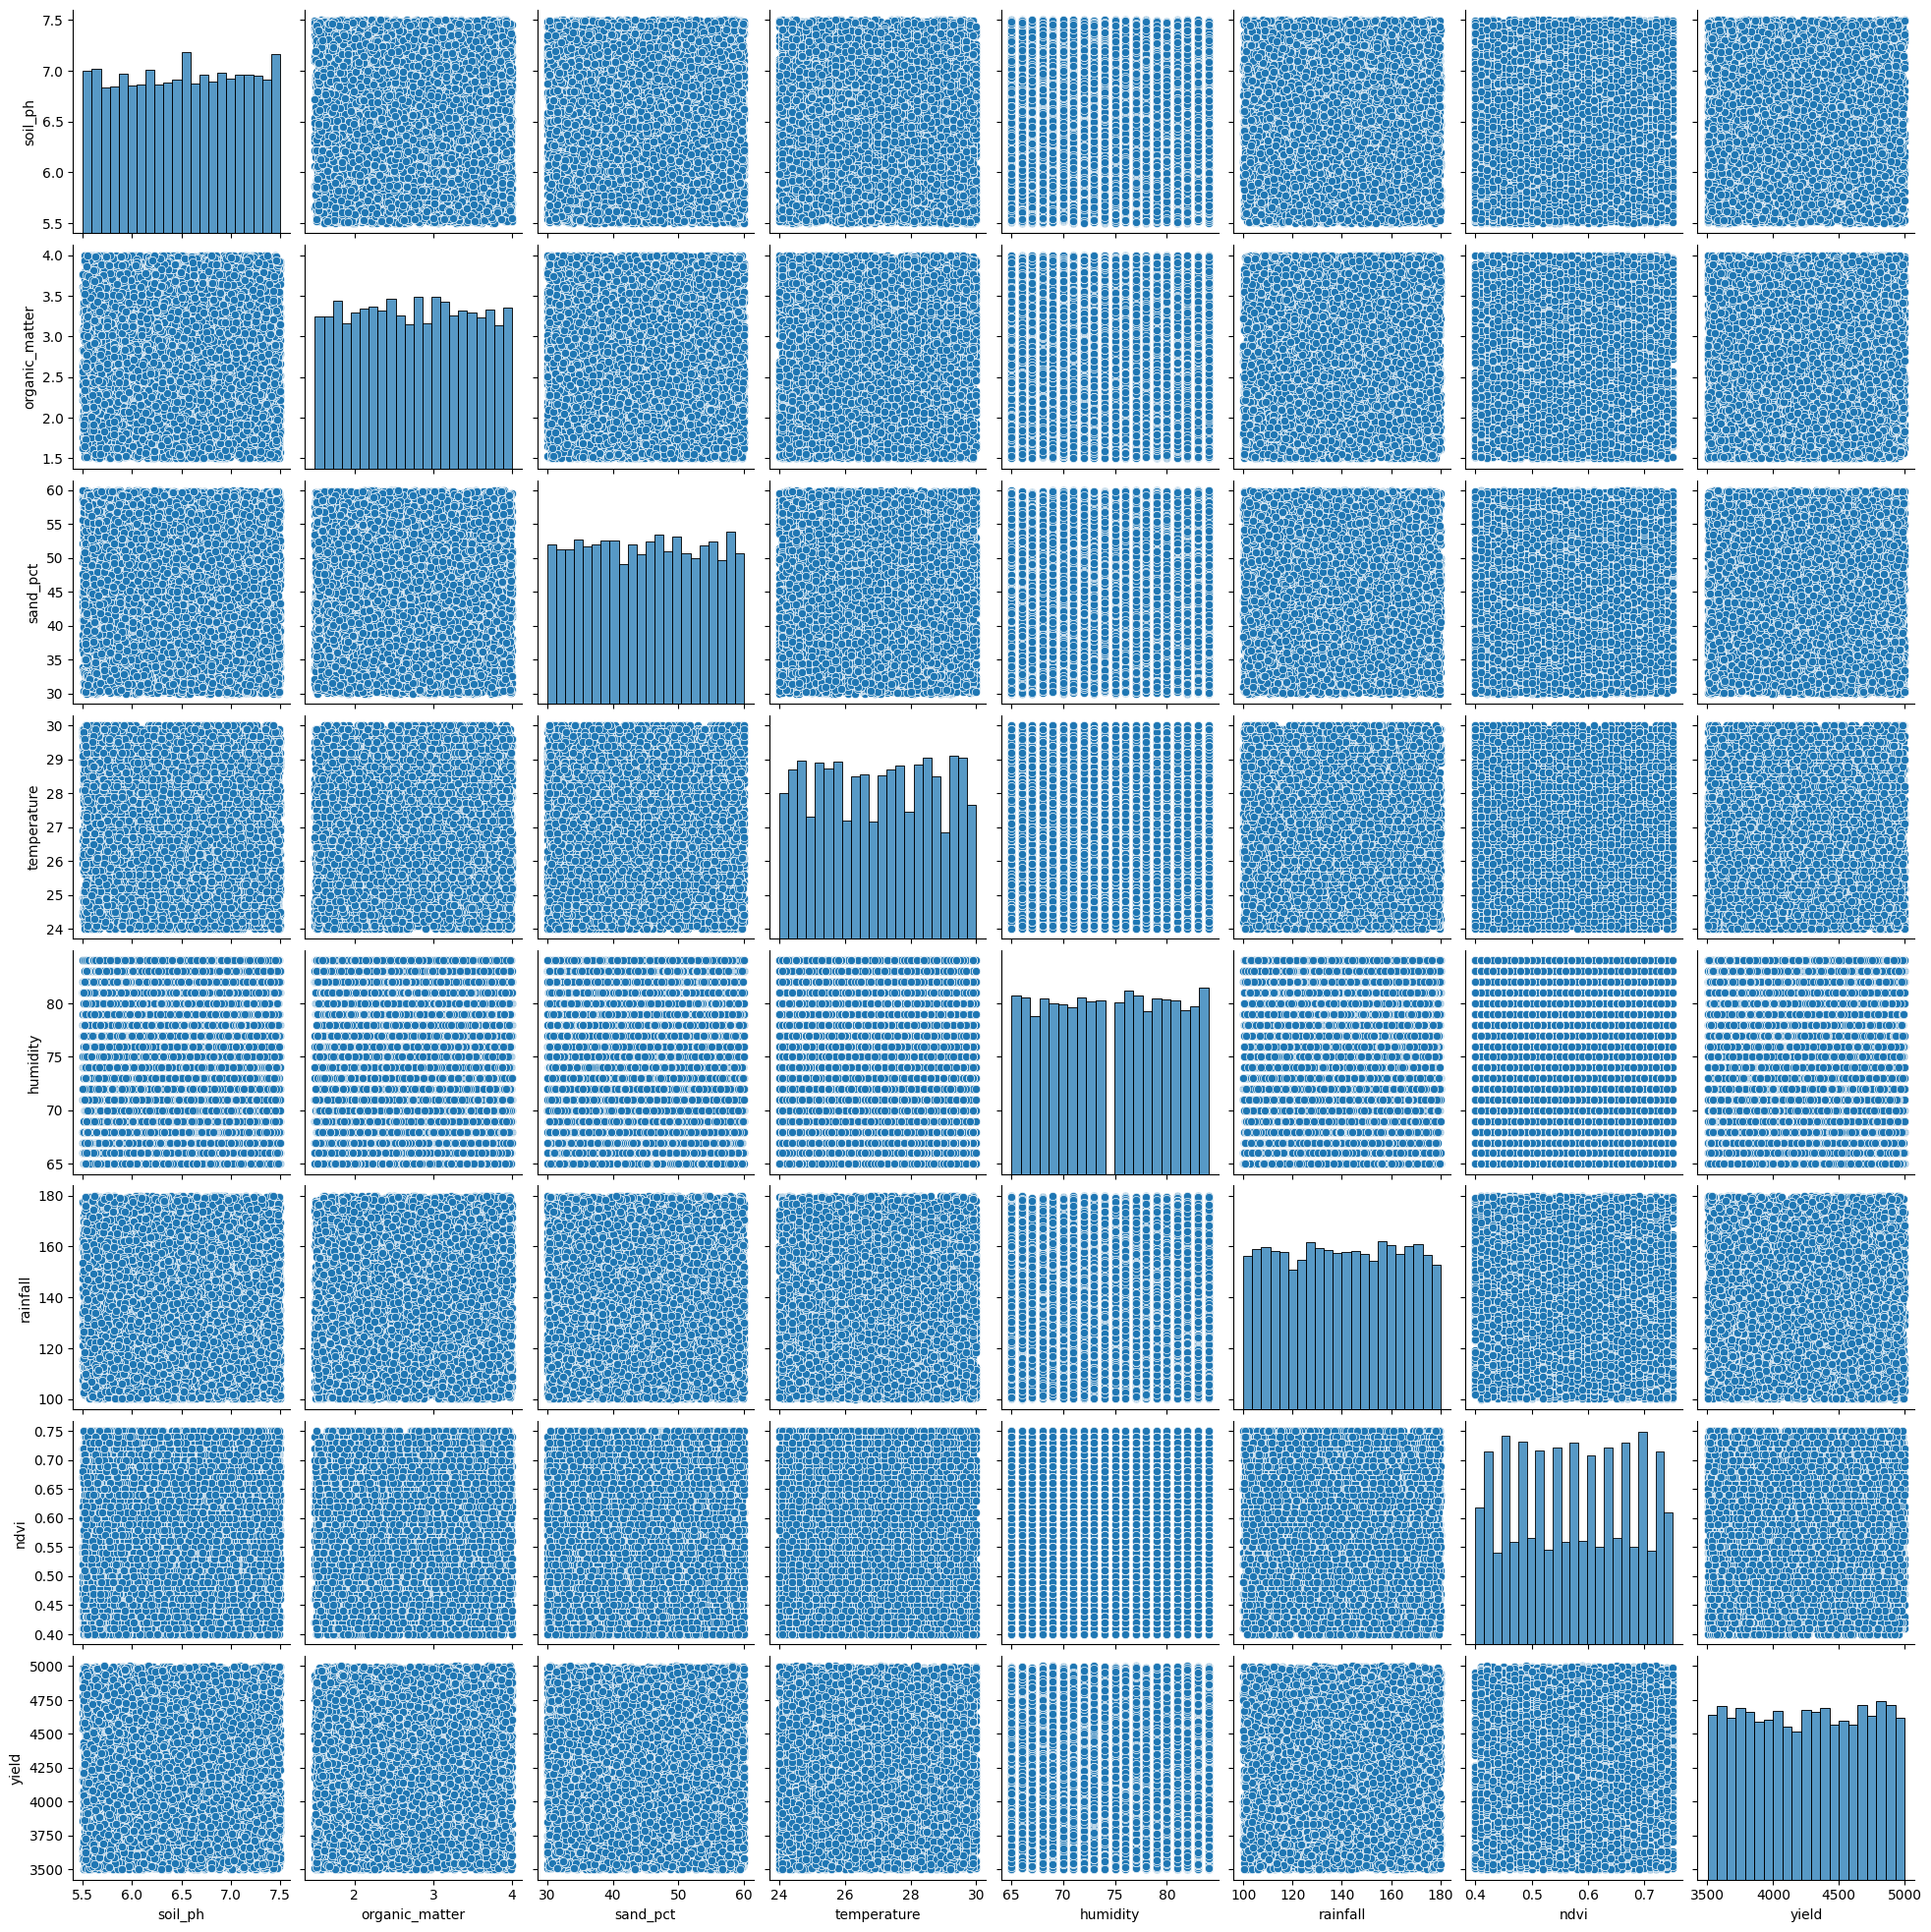

In [8]:
#Pairplot Overview of all variables
sns.pairplot(df)

In [9]:
#Brief stats overview
df.describe()

soil_ph  organic_matter     sand_pct   temperature      humidity  \
count  10000.000000    10000.000000  10000.00000  10000.000000  10000.000000   
mean       6.508556        2.748447     44.95785     26.993920     74.523400   
std        0.579959        0.717645      8.65291      1.736847      5.775101   
min        5.500000        1.500000     30.00000     24.000000     65.000000   
25%        6.000000        2.130000     37.50000     25.500000     70.000000   
50%        6.510000        2.750000     45.00000     27.000000     75.000000   
75%        7.010000        3.360000     52.40000     28.500000     80.000000   
max        7.500000        4.000000     60.00000     30.000000     84.000000   

           rainfall          ndvi         yield  
count  10000.000000  10000.000000  10000.000000  
mean     140.033850      0.574883   4251.976400  
std       23.026794      0.100168    436.533109  
min      100.000000      0.400000   3500.200000  
25%      120.200000      0.490000   3868.050000  
50%      140.100000      0.570000   4257.150000  
75%      160.200000      0.660000   4638.325000  
max      180.000000      0.750000   5000.000000

In [10]:
#Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   field_id        10000 non-null  object 
 1   soil_ph         10000 non-null  float64
 2   organic_matter  10000 non-null  float64
 3   sand_pct        10000 non-null  float64
 4   temperature     10000 non-null  float64
 5   humidity        10000 non-null  int64  
 6   rainfall        10000 non-null  float64
 7   ndvi            10000 non-null  float64
 8   yield           10000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 703.3+ KB


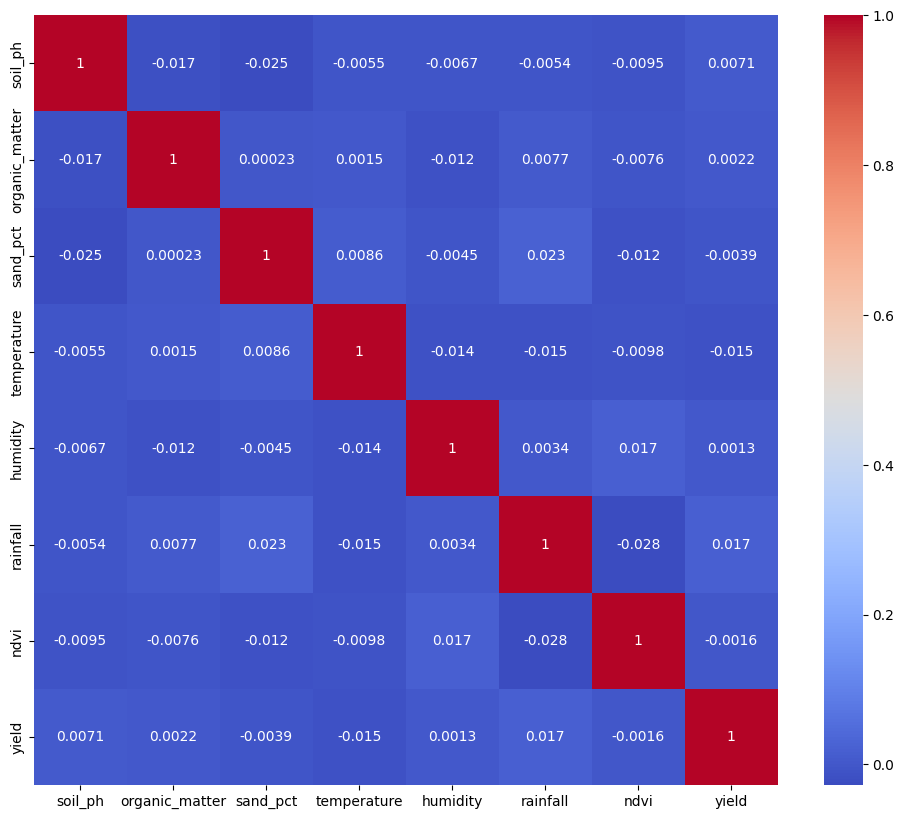

In [11]:
#Heatmap for quick correlation overview. No one value shouting out.
num_cols = df.select_dtypes(include = ['int64', 'float64'])
plt.figure(figsize = (12, 10))
sns.heatmap(num_cols.corr(), annot = True, cmap = 'coolwarm')
plt.show()

## Model Testing

Will trial several different model types and evaluate performance using RMSE as the evaluation metric. The best performing model on the training data will be used to on the test data to create the submission csv.

### Multiple Linear Regression

Using Rainfall and Temperate as input for a basic multiple linear regression. These two inputs chosen as the correlation heatmap showed they had the strongest correlation with yield (however, still weakly).

Mean Squared: 189313.3334229561
Mean Absolute: 376.83168881125704
Root Mean Squared: 435.10152082353846
R2: 0.0008458083342393063


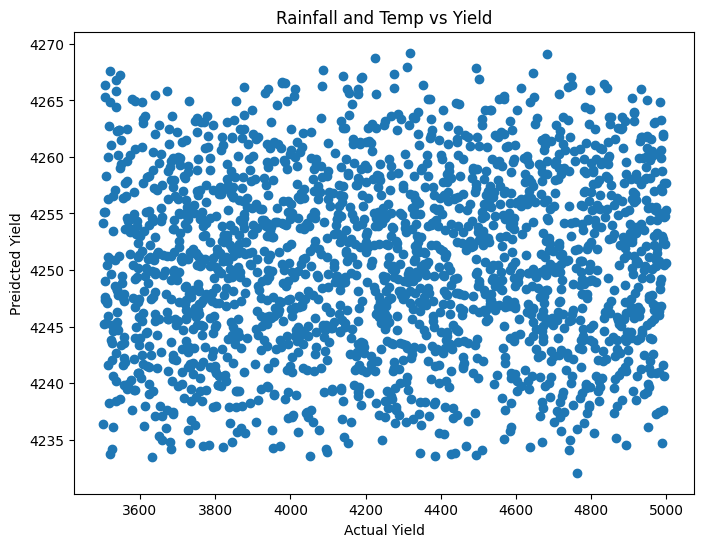

In [12]:
#Define input and target features
feature_names = ['rainfall', 'temperature']

x = df[feature_names]
y = df['yield']

#Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Scale data
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)

#Create Multiple Regression Model
MultipleRegression = LinearRegression()
MultipleRegression.fit(x_train_scaled, y_train)

#Generate Predictions
yield_predictions = MultipleRegression.predict(x_test_scaled)

#Error Scoring Evaluation
mse = mean_squared_error(y_test, yield_predictions)
mae = mean_absolute_error(y_test, yield_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yield_predictions)

print(f'Mean Squared: {mse}')
print(f'Mean Absolute: {mae}')
print(f'Root Mean Squared: {rmse}')
print(f'R2: {r2}')

#Visualise Predicted vs Actual
plt.figure(figsize = (8, 6))
plt.scatter(y_test, yield_predictions)
plt.xlabel('Actual Yield')
plt.ylabel('Preidcted Yield')
plt.title('Rainfall and Temp vs Yield')
plt.show()

### Forest Regression

Will Run Random Forest Regression with field ID encoded to numerical data and input all available variables. Should perform better than multiple Linear Regression. If results are promising will potentially move into XGBoost and compare performance.

Mean Absolute: 381.21886950000004
Mean Squared: 196601.2754658965
Root Mean Squared: 443.39742383768595
R2: -0.03761834899245242


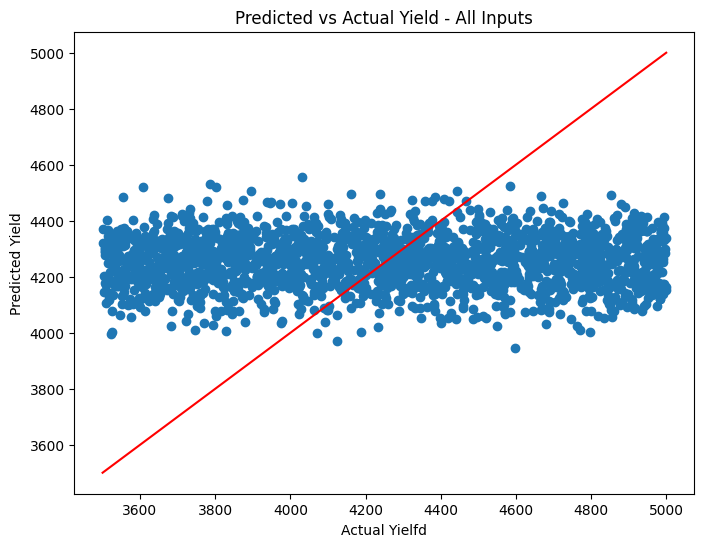

In [13]:
#Data prep and encoding of field_id
num_features = ['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']

cat_features = ['field_id']

preprocessor = ColumnTransformer(transformers = [
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_features)
])

#Define inputs
x = df[num_features + cat_features]
y = df['yield']

#Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Transform data using preprocessor
x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

#Create Forest Regressor Model
yield_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
yield_model.fit(x_train_transformed, y_train)

#Create Predictions
yield_predictions = yield_model.predict(x_test_transformed)

#Error Scoring
mean_abs = mean_absolute_error(y_test, yield_predictions)
mean_sq = mean_squared_error(y_test, yield_predictions)
rms_error = np.sqrt(mean_sq)
r2 = r2_score(y_test, yield_predictions)

print(f'Mean Absolute: {mean_abs}')
print(f'Mean Squared: {mean_sq}')
print(f'Root Mean Squared: {rms_error}')
print(f'R2: {r2}')

#Visualise
max_val = max(y_test.max(), yield_predictions.max())
min_val = min(y_test.min(), yield_predictions.min())

plt.figure(figsize = (8, 6))
plt.scatter(x = y_test, y = yield_predictions)
plt.plot([min_val, max_val], [min_val, max_val], color = 'red')
plt.ylabel('Predicted Yield')
plt.xlabel('Actual Yielfd')
plt.title('Predicted vs Actual Yield - All Inputs')
plt.show()


Mean Absolute: 380.1938585
Mean Squared: 196226.70568541047
Root Mean Squared: 442.9748364020359
R2: -0.03564145196424473


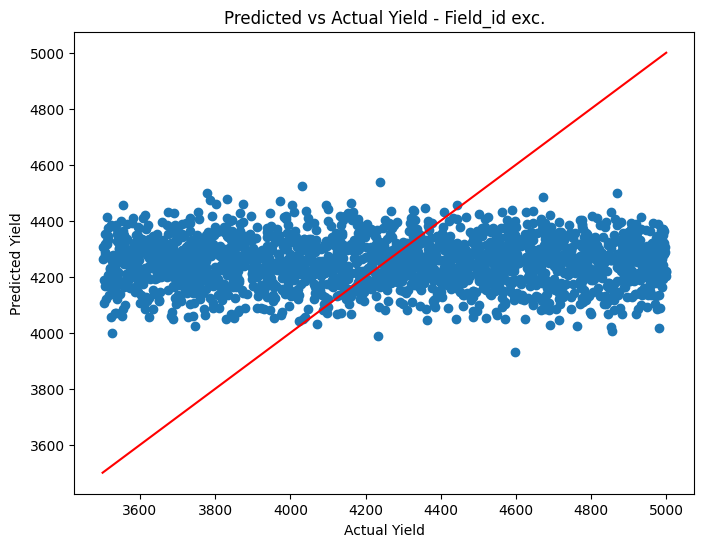

In [14]:
#Will re-run without field_id
#No pre-processing needed since remaing inputs are all numerical
input_features = ['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']

#Define inputs
x = df[input_features]
y = df['yield']

#Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Run Forest Regressor
yield_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
yield_model.fit(x_train, y_train)

#Create Predictions
yield_predictions = yield_model.predict(x_test)

#Error Scoring
mean_abs = mean_absolute_error(y_test, yield_predictions)
mean_sq = mean_squared_error(y_test, yield_predictions)
rms_error = np.sqrt(mean_sq)
r2 = r2_score(y_test, yield_predictions)

print(f'Mean Absolute: {mean_abs}')
print(f'Mean Squared: {mean_sq}')
print(f'Root Mean Squared: {rms_error}')
print(f'R2: {r2}')

#Visualise
max_val = max(y_test.max(), yield_predictions.max())
min_val = min(y_test.min(), yield_predictions.min())

plt.figure(figsize = (8, 6))
plt.scatter(x = y_test, y = yield_predictions)
plt.plot([min_val, max_val], [min_val, max_val], color = 'red')
plt.ylabel('Predicted Yield')
plt.xlabel('Actual Yield')
plt.title('Predicted vs Actual Yield - Field_id exc.')
plt.show()


### XGBoost

Will run an XGBoost model to compare to Random forest, potential improvement but not expecting vast changes. First will create a baseline model, then determine best parameters for fine tuning, and create a final model.

#### Baseline XGBoost Model

RMSE: 448.08229757673934


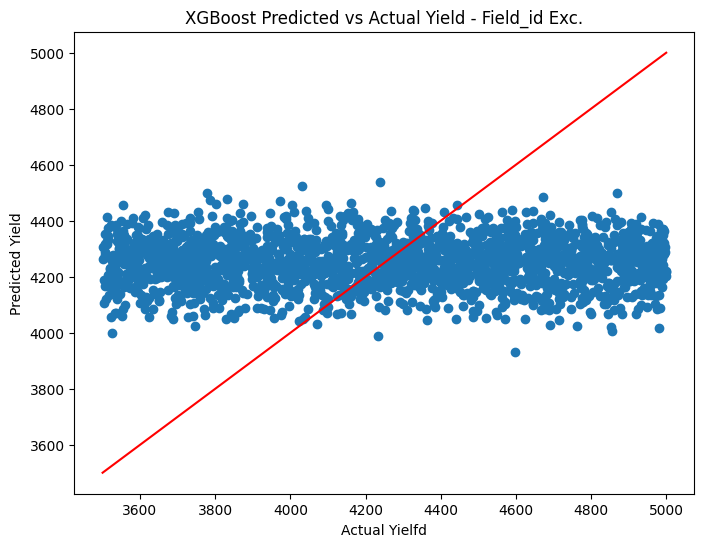

In [17]:
#Define input variables and target - no field_id for this
x = df[['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']]

y = df['yield']

#Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Convert data in XGBoost happy shape, use .values otherwise will throw an error
#Could use a wrapper, but this seemed happier to run
dtrain = xgb.DMatrix(x_train.values, label = y_train.values)
dtest = xgb.DMatrix(x_test.values, label = y_test.values)

#set params for XGboost
params = {
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
    'seed' : 42,
    'max_depth' : 5,
    'eta' : 0.05
}

num_rounds = 500

#train model
xgb_model = xgb.train(params, dtrain, num_rounds)

#Create predictoins using test data
yield_preds = xgb_model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, yield_preds))
print(f'RMSE: {rmse}')

#Visualise prediction accuracy
plt.figure(figsize = (8, 6))
plt.scatter(x = y_test, y = yield_predictions)
plt.plot([min_val, max_val], [min_val, max_val], color = 'red')
plt.ylabel('Predicted Yield')
plt.xlabel('Actual Yielfd')
plt.title('XGBoost Predicted vs Actual Yield - Field_id Exc.')
plt.show()



#### RandomizedSearchCV for best Parameters

Will run randomized search for XGBoost to find more optimal parameters from a designated range.

In [18]:
#Define input variables - no field_id for this
x = df[['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']]

y = df['yield']

#Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

xgb_model = XGBRegressor(objective = 'reg:squarederror', seed = 42)

#Set parameters for search
param_grid = {
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.05, 0.1, 0.2],
    'n_estimators' : [100, 200, 300],
    'subsample' : [0.8, 0.9, 1],
    'colsample_bytree' : [0.7, 0.8, 1]
}

#Use random search on param grid
random_search = RandomizedSearchCV(
    xgb_model, param_distributions = param_grid,
    n_iter = 20, cv = 3, scoring = 'neg_mean_squared_error',
    verbose = 1, random_state = 42
)

#Apply Random Seacrch
random_search.fit(x_train, y_train)

#Print best parameters from the search
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(best_params)
print(best_model)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'subsample': 0.9, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)


#### XGBoost Tuned

Now run XGBoost using the best parameters found from random search. Performance should be improved

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:20:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RMSE: 438.4327242084002


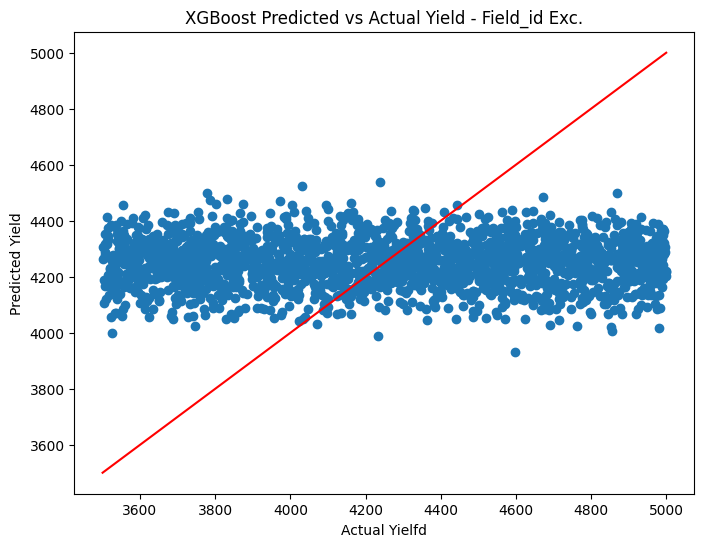

In [19]:
#Define input variables - no field_id for this
x = df[['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']]

y = df['yield']

#Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Convert data in XGBoost happy shape, use .values otherwise will throw an error
dtrain = xgb.DMatrix(x_train.values, label = y_train.values)
dtest = xgb.DMatrix(x_test.values, label = y_test.values)

#set params for XGboost
params = {
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
    'seed' : 42,
    'max_depth' : 3,
    'eta' : 0.05,
    'n_estimators' : 100,
    'subsample' : 0.9,
    'colsample_bytree' : 0.8
}

num_rounds = 500

#train model
xgb_model_tuned = xgb.train(params, dtrain, num_rounds)

#Create predictoins using test data
yield_preds = xgb_model_tuned.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, yield_preds))
print(f'RMSE: {rmse}')

#Visualise prediction accuracy
plt.figure(figsize = (8, 6))
plt.scatter(x = y_test, y = yield_predictions)
plt.plot([min_val, max_val], [min_val, max_val], color = 'red')
plt.ylabel('Predicted Yield')
plt.xlabel('Actual Yielfd')
plt.title('XGBoost Predicted vs Actual Yield - Field_id Exc.')
plt.show()

### Neural Network

Will create a baseline ANN with basic structure and assess on the training data. Will run RandomizedSearch to help tune parameters and assess the performance of training on a tuned model.

#### Baseline Model

In [20]:
#Define and input x and y variables
input_features = ['soil_ph', 'organic_matter', 'sand_pct', 'temperature',
                  'humidity', 'rainfall', 'ndvi']

x = df[input_features]
y = df['yield']

#split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#scale x data
scaler = StandardScaler()
x_train_transformed = scaler.fit_transform(x_train)
x_test_transformed = scaler.transform(x_test)

#create baseline model structure
model = Sequential()

model.add(Dense(units = 64, input_dim = x_train_transformed.shape[1], activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))

#Compile model using Adam Optimizer
adam = Adam(learning_rate = 0.01)
model.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

#Define callback option
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)

#Run model training
history = model.fit(x = x_train_transformed, y = y_train, validation_split = 0.2,
                    epochs = 50, batch_size = None, verbose = 'auto',
                    callbacks = [early_stopping])



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12102510.0000 - mean_squared_error: 12102510.0000 - val_loss: 287494.0000 - val_mean_squared_error: 287494.0000
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 645984.4375 - mean_squared_error: 645984.4375 - val_loss: 248930.7344 - val_mean_squared_error: 248930.7344
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 564375.9375 - mean_squared_error: 564375.9375 - val_loss: 214409.2188 - val_mean_squared_error: 214409.2188
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 485696.2812 - mean_squared_error: 485696.2812 - val_loss: 191124.3125 - val_mean_squared_error: 191124.3125
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 433349.9062 - mean_squared_error: 433349.9062 - val_loss: 202283.7969 - val_mean_squared_error: 202283.7969
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 423781.7500 - mean_squared_error: 423781.7500 - val_loss: 191169.5781 - val_mean_squared_error: 191169.5781

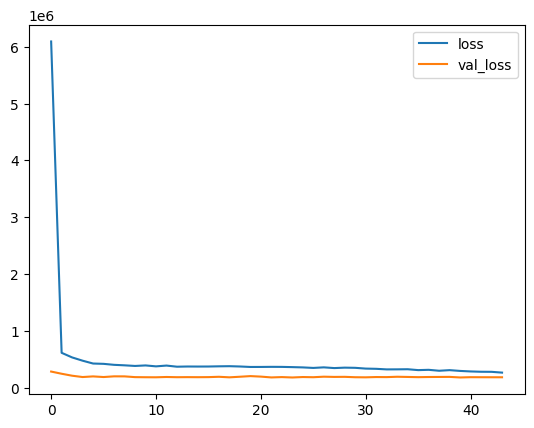

In [21]:
#Plot model loss and val loss
model_df = pd.DataFrame(history.history)
plt.plot(model_df['loss'], label = 'loss')
plt.plot(model_df['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

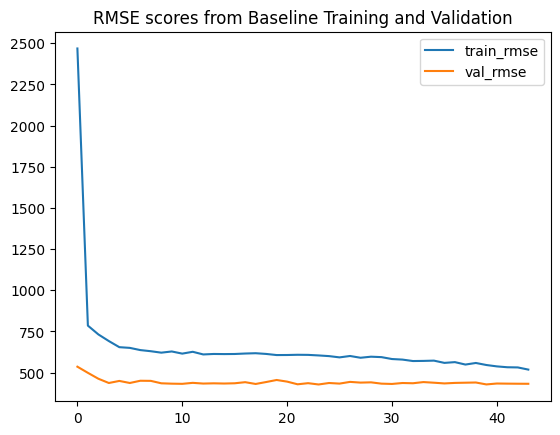

In [22]:
#plot model RMSE
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.plot(train_rmse, label = 'train_rmse')
plt.plot(val_rmse, label = 'val_rmse')
plt.title('RMSE scores from Baseline Training and Validation')
plt.legend()
plt.show()

#### RandomizedSearchCV for Tuning

In [28]:
#Create function to define a model structure
def create_model(learning_rate = 0.001, hidden_layers = 2, neurons = 64):
  model = Sequential()
  model.add(Dense(units = neurons, input_dim = x_train_transformed.shape[1], activation = 'relu'))
  model.add(Dropout(0.2))
  for i in range(hidden_layers - 1):
    model.add(Dense(units = neurons, activation = 'relu'))
  model.add(Dense(units = neurons, activation = 'relu'))
  model.add(Dense(units = 1, activation = 'linear'))
  model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'mean_squared_error')

  return model

#call function to build new regression model each time within Regressor
regressor = KerasRegressor(model = create_model, verbose = 0)

#Define paramter ranges
param_grid = {
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__neurons': [32, 64, 128],
    'model__hidden_layers': [1, 2, 3],
    'batch_size': [32, 64],
    'epochs': [20, 50, 100]
}

#Define Random Search
random_search = RandomizedSearchCV(
    regressor, param_distributions = param_grid,
    n_iter = 10, cv = 3, scoring = 'neg_mean_squared_error',
    random_state = 42
)

#Run Random Search
random_search.fit(x_train_transformed, y_train)

#Print best parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(best_params)
print(best_model)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

{'model__neurons': 32, 'model__learning_rate': 0.01, 'model__hidden_layers': 3, 'epochs': 50, 'batch_size': 32}
KerasRegressor(
	model=<function create_model at 0x78e0180d09a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	model__neurons=32
	model__learning_rate=0.01
	model__hidden_layers=3
)


#### Tuned ANN Model

In [32]:
#create tuned model structure
model = Sequential()

model.add(Dense(units = 32, input_dim = x_train_transformed.shape[1], activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 1, activation = 'linear'))

adam = Adam(learning_rate = 0.01)

model.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)

history = model.fit(x = x_train_transformed, y = y_train, validation_split = 0.2,
                    epochs = 50, batch_size = 32, verbose = 0, callbacks = [early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


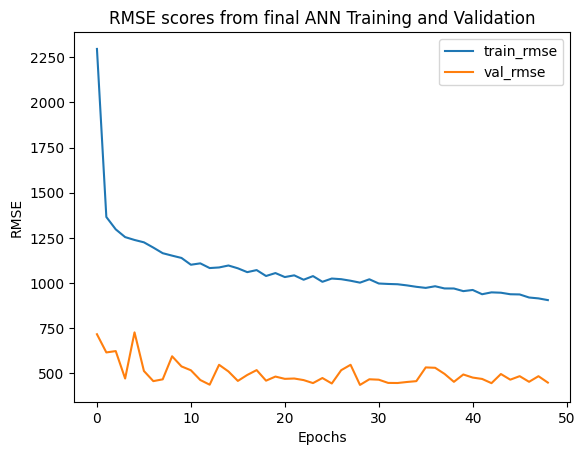

In [33]:
#Plot RMSE from Training
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.plot(train_rmse, label = 'train_rmse')
plt.plot(val_rmse, label = 'val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE scores from final ANN Training and Validation')
plt.legend()
plt.show()

## Model Training Comparison

The Tuned XGBoost performed most effectively with RMSE of 438, followed by RandomForest(Without Field_id) at RMSE 442, and RandomForest(With field_id) at 443. The tuned ANN performed worse than expected with RMSE close to 500.

Will therefore create the test predictions using the tuned XGBoost Model

## XGBoost Final Model Testing and CSV Submission

The tuned XGBoost model has provided the best RMSE scores, so will use this model to create a submission.csv using the test.csv data.

In [35]:
test_df = pd.read_csv('agri_yield_data/test.csv')

x_test_final = test_df[['soil_ph', 'organic_matter', 'sand_pct',
                'temperature', 'humidity', 'rainfall', 'ndvi']]

dtest_final = xgb.DMatrix(x_test_final.values)

test_preds = xgb_model_tuned.predict(dtest_final)

In [36]:
#generate submission
submission = pd.DataFrame({
    'field_id': test_df['field_id'],
    'yield': test_preds
})

submission.to_csv('submission.csv', index = False)

print(submission.head())

  field_id        yield
0   T00001  4237.786621
1   T00002  4288.097168
2   T00003  4230.804688
3   T00004  4231.202637
4   T00005  4127.169922


## Create Requirements Text

In [37]:
#Generate Requirements Text

requirements = """numpy
pandas
matplotlib
seaborn
scikit-learn
xgboost
scikeras
tensorflow
"""

with open('requirements.txt', 'w') as f:
  f.write(requirements)